In [ ]:
# %% Import Statements
import copy
import math
import heapq
import pickle
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.optimize import curve_fit
from collections import defaultdict, Counter

In [ ]:
# %% Load and Store Sensors
sensors = None
with (open("sensors.pkl", "rb")) as file:
      sensors = pickle.load(file)

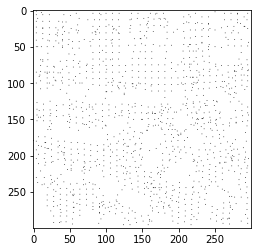

In [ ]:
# %% Display the Grid
grid = np.ones((300, 300))
for node in sensors:
    r = node[0]
    c = node[1]
    grid[r][c] = 0

plt.imshow(grid, cmap=plt.cm.gray)

In [ ]:
# %% Testing Block
'''
map = np.zeros((810, 1210))
for i in range(10):
    for j in range(10):
        img_name = 'row-' + str(i+1) + '-column-' + str(j+1) + '.png'
        img = Image.open(img_name)
        img = img.convert('L')
        img = np.asarray(img) / 255
        map[81*i:81*(i+1), 121*j:121*(j+1)] = img[0:81, 0:121]

# Display the original map
plt.imshow(map,plt.cm.gray)
plt.show()

# Display the map used for the project
map = map[:300,:300]
plt.imshow(map,plt.cm.gray)
plt.show()
'''

"\nmap = np.zeros((810, 1210))\nfor i in range(10):\n    for j in range(10):\n        img_name = 'row-' + str(i+1) + '-column-' + str(j+1) + '.png'\n        img = Image.open(img_name)\n        img = img.convert('L')\n        img = np.asarray(img) / 255\n        map[81*i:81*(i+1), 121*j:121*(j+1)] = img[0:81, 0:121]\n\n# Display the original map\nplt.imshow(map,plt.cm.gray)\nplt.show()\n\n# Display the map used for the project\nmap = map[:300,:300]\nplt.imshow(map,plt.cm.gray)\nplt.show()\n"

In [ ]:
# %% Utility Functions

# Specifies function for curve_fit
def fit_line(x, m, b):
    return m*x + b

# Finds the list of sensors in the 5x5 path between two coordinates
def num_sensors_eliminated(all_loc, loc_1, loc_2):
    '''
    Finds the locations of all the sensors that lie in the aggregate 5x5 channel
    path between two coordinate locations.

    Inputs:
        - all_loc -> numpy ndarray
        - loc_1 -> tuple (row, column)
        - loc_2 -> tuple (row, column)
    Outputs:
        - ret_arr -> list
    '''
    
    ret_arr = []
    #first exchange the coordinates of loc_1 and loc_2 so that loc_1 is on the left of loc_two
    new_1, new_2 = (0,0), (0,0)
    if loc_1[1] < loc_2[1]:
        new_1, new_2 = loc_1, loc_2
    else:
        new_1, new_2 = loc_2, loc_1
    #case 1: loc_1 and loc_2 are on the same row
    if new_1[0] == new_2[0]:
        for loc in all_loc:
            if loc[1] >= new_1[1]-2 and loc[1] <= new_2[1]+2 and loc[0] >= new_1[0]-2 and loc[0] <= new_1[0]+2:
                ret_arr.append(loc)
    #case 2: loc_1 and loc_2 are on the same column
    elif loc_1[1] == loc_2[1]:
        for loc in all_loc:
            if loc[0] >= min(new_1[0],new_2[0])-2 and loc[0] <= max(new_1[0],new_2[0])+2 and loc[1] >= new_1[1]-2 and loc[1] <= new_1[1]+2:
                #print(loc)
                ret_arr.append(loc)
    #case 3: 
    else:
        popt, pcov = curve_fit(fit_line,[new_1[1], new_2[1]], [new_1[0], new_2[0]])
        # If slope < 0
        if (abs(popt[0]) < 0):
            #upper curve
            popt_1, pcov_1 = curve_fit(fit_line,[new_1[1]+3, new_2[1]+3], [new_1[0]+3, new_2[0]+3])
            #lower curve
            popt_2, pcov_2 = curve_fit(fit_line,[new_1[1]-2, new_2[1]-2], [new_1[0]-2, new_2[0]-2])

            for loc in all_loc:
                if (loc[0] < new_1[0]+3 and loc[0] >= new_2[0]-2) and (loc[1] < new_2[1]+3 and loc[1] >= new_1[1]-2):
                    if loc[0] <= fit_line(loc[1],*popt_1) and loc[0] >= fit_line(loc[1],*popt_2):
                        ret_arr.append(loc)
        # If slope > 0 degrees
        else: 
            #upper curve
            popt_1, pcov_1 = curve_fit(fit_line,[new_1[1]-2, new_2[1]-2], [new_1[0]+3, new_2[0]+3])
            #lower curve
            popt_2, pcov_2 = curve_fit(fit_line,[new_1[1]+3, new_2[1]+3], [new_1[0]-2, new_2[0]-2])

            for loc in all_loc:
                if (loc[0] < new_2[0]+3 and loc[0] >= new_1[0]-2) and (loc[1] < new_2[1]+3 and loc[1] >= new_1[1]-2):
                    if loc[0] <= fit_line(loc[1],*popt_1) and loc[0] >= fit_line(loc[1],*popt_2):
                        ret_arr.append(loc)
    return ret_arr

In [ ]:
# %% Path Finding Functions

# Calculates mini-squares on the map
def square_cycles_size_n(n, grid, all_loc):
    '''
    Computes the sets of sensors in a predefined square size, or in
    this case an optimal length of side 6. By calculating sensor densities, it
    results in the optimal, highly efficient grouped locations.

    Inputs:
        - n -> int
        - grid -> numpy ndarray
        - all_loc -> list
    Outputs:
        - coord -> list
        - cover_dict -> dict
    '''

    coord = []
    cover_dict = defaultdict(list)
    #traverse through the sensor grid to first realize the coordinate of every single square of side length n
    for i in range(len(grid)-n+1):
        for j in range(len(grid[0])-n+1):
            corner = []
            corner.append((i,j))
            corner.append((i+n,j))
            corner.append((i,j+n))
            corner.append((i+n,j+n))
            coord.append(corner)
    count = 0
    #traverse through the coordinates to realize the sensor locations covered through each arbitrary "semi-square"
    for row in coord:
        #print(count)
        l2 = num_sensors_eliminated(all_loc, row[0], row[2])
        l3 = num_sensors_eliminated(all_loc, row[1], row[3])
        l4 = num_sensors_eliminated(all_loc, row[2], row[3])
        sensors_covered = []
        for i in l2:
            sensors_covered.append(i)
        for i in l3:
            sensors_covered.append(i)
        for i in l4:
            sensors_covered.append(i)  
        cover_dict[row[0]] = set(sensors_covered)
        count+=1
    return coord, cover_dict

# Computes the minimum set cover of our path segments
def min_set_cover(cover_dict,all_loc):
    '''
    Computes the minimum set cover between our defined square segments on the 
    grid. The algorithm employs gradient search to find the highest density.

    Inputs:
        - cover_dict -> dict
        - all_loc -> list
    Outputs:
        - min_cov_dict -> dict
    '''

    min_cov_dict = defaultdict(list)
    #set used to remove already covered elements
    #when length reaches 0, that means all sensors have been covered
    loc_set = set(copy.deepcopy(all_loc))
    #cover_dict deep copy so that we could remove elements
    cover_dict_cop = copy.deepcopy(cover_dict)
    while True:
        max_len = 0
        most_coord = (-1,-1)
        #repeatedly iterate through the cover_dict, 
        #and greedily find out the keys that has the most number of intersection with the set of all sensors.
        #when all sensor locations have been covered, return the dictionary of edge locations with sensors covered as values.
        for k in cover_dict_cop.keys():
            len_inter = len(set(cover_dict_cop[k]).intersection(loc_set))
            if  len_inter > max_len:
                most_coord = k
                max_len = len_inter
        min_cov_dict[most_coord] = cover_dict_cop[most_coord]
        loc_set = loc_set - set(cover_dict_cop[most_coord])
        del cover_dict_cop[most_coord]
        if len(loc_set) == 0:
            break
    return min_cov_dict

# Optimizes sensor set definition
def edges_path(n, grid, sensors):
    '''
    Prunes our grid of sensors to eliminate weightless sides of the square. 

    Inputs:
        - n -> int
        - grid -> numpy ndarray
        - sensors -> list
    Outputs:
        - edge_collection -> defaultdict
    '''

    coord, cover_dict = square_cycles_size_n(n, grid, sensors)
    min_cov_dict = min_set_cover(cover_dict,sensors)
    edge_collection = defaultdict(list)
    #iterate throught the min_cov_dict to see which edges are useless
    #return the edge_collection of useful edges
    for cyc_loc in min_cov_dict.keys():
        right = num_sensors_eliminated(sensors, cyc_loc, (cyc_loc[0],cyc_loc[1]+n))
        #up = num_sensors_eliminated(sensors, cyc_loc, (cyc_loc[0]+n,cyc_loc[1]))
        up_right = num_sensors_eliminated(sensors, (cyc_loc[0]+n,cyc_loc[1]), (cyc_loc[0]+n,cyc_loc[1]+n))
        right_up = num_sensors_eliminated(sensors, (cyc_loc[0],cyc_loc[1]+n), (cyc_loc[0]+n,cyc_loc[1]+n))
        if len(right) > 0:
            edge_collection[(cyc_loc, (cyc_loc[0],cyc_loc[1]+n))] = right
        if len(up_right) > 0:
            edge_collection[((cyc_loc[0]+n,cyc_loc[1]), (cyc_loc[0]+n,cyc_loc[1]+n))] = up_right
        if len(right_up) > 0:
            edge_collection[((cyc_loc[0],cyc_loc[1]+n), (cyc_loc[0]+n,cyc_loc[1]+n))] = right_up

    return edge_collection

# Optimizes the workload split between multiple drones
def partition_algorithm(center_loc,sensors, all_edges, n, max_sensors, distance_constraint,number_drones):
    '''
    Divides workload by employing equality principle, such that no one drone is
    actually overworked. This ensures more balanced division of labor, in such a
    manner that the deployment time is at a minimum.

    Inputs:
        - center_loc -> tuple (row, column)
        - sensors -> list
        - all_edges -> list
        - n -> int
        - max_sensors -> int
        - distance_constraint -> int
        - number_drones -> int
    Outputs:
        - list_of_dict_edges -> list
    '''

    #determine the number of slices we want to partition the plane of edges, 
    #considering fuel constraint, sensor carrying capacity, and the loss from traversing the min_set covers
    sections_sensor_constraint = math.ceil((len(sensors)/max_sensors)*4 + 1)
    sections_distance_constraint = math.ceil(len(all_edges)/(distance_constraint/n/2.5) + 1)
    num_sections = max(sections_sensor_constraint,sections_distance_constraint,number_drones + 2)
    #serve as a threshold for the polar coordinate degress to stop
    ave_edges = len(all_edges)/num_sections
    #convert the edge_min_set_cover to polar coordinates to partition then store in a new dictionary,
    #which has edges as the key, and the degree with relation to the sink as values, in radians
    edge_polar_dic = defaultdict(float)
    for ele in list(edge_min_set_cov.keys()):
        temp_ele = None
        if ele[0] != center_loc:
            temp_ele = ele[0]
        else:
            temp_ele = ele[1]
        #using acos to determine the degree from theta = 0
        edge_polar_dic[ele] = math.acos((temp_ele[1]-center_loc[1])/math.sqrt((temp_ele[0]-center_loc[0])**2 + (temp_ele[1]-center_loc[1])**2))
        #since cos(theta) = cos(-theta), 
        #the only way to obtain pi to 2pi value from acos is to consider the third and forth coordinate separately
        if temp_ele[0]-center_loc[0] < 0:
            edge_polar_dic[ele] = 2*math.pi - edge_polar_dic[ele]
    #sort the edges by radians, in order to partition radially
    edge_polar_dic = dict(sorted(edge_polar_dic.items(), key=lambda item: item[1]))
    #each list in all_edge_partitioned is a collection of edges in the form (coord1,coord2)
    all_edge_array = list(edge_polar_dic)
    all_edge_partitioned = [all_edge_array[i*int(ave_edges):(i+1)*int(ave_edges)] for i in range(num_sections-1)]
    all_edge_partitioned.append(all_edge_array[(num_sections-1)*int(ave_edges):])
    list_of_dict_edges = []
    #print(all_edge_partitioned)
    for p in all_edge_partitioned:
        temp_dict = defaultdict(list)
        for k in p:
            temp_dict[k] = all_edges[k]
        list_of_dict_edges.append(temp_dict)
    return list_of_dict_edges

# Splits paths among the drones as equally as possible
def lists_of_similar_weight(path_lengths, n_drones):
    '''
    Utilizes the heap to ensure maximum equality split.

    Inputs:
        - path_lengths -> list
        - n_drones -> int
    Outputs:
        - list_each_drone -> list
    '''

    totals = [(0, i) for i in range(n_drones)]
    heapq.heapify(totals)
    list_each_drone = [[] for _ in range(n_drones)]
    for value in path_lengths:
        total, index = heapq.heappop(totals)
        list_each_drone[index].append(value)
        heapq.heappush(totals, (total + value, index))
    return list_each_drone

#Intuition: Between two sets of "semi-square," we would like to find the points from each set to connect.
#           However, the points to connect couldn't be "in-between vertices," so we look for vertices in sets with degree 1.
#           Then, we return the distance given the above constraint and coordinates in each sets
#
#input: two sets that we want to find the distance between
#output: 1. the best distance between two sets, given that the point of connection has degree 1
#        2. The two coordinates in the two sets that we would like to connect
#since each set is a collection of edges, and some edges might be "in between" two edges, we want to only look at the edge vertices

# Calculates the connecting distance between two sets of sensors
def dist_pt_sets(set_1, set_2):
    '''
    Finds the locations of connections between different sets of sensors, and
    additionally calculates this distance. 

    Inputs:
        - set1 -> list
        - set2 -> list
    Outputs:
        - bsf -> int
        - coord_in_1 -> tuple (row, column)
        - coord_in_2 -> tuple (row, column)
    '''

    set_1_reduced = []
    set_2_reduced = []
    all_coord_1 = []
    all_coord_2 = []
    #first append all coordinates in the edges
    #then see if the degrees of the edge coordinates is 1
    #if not, it means that the edge is in between two edges
    #do the same for set_2 to reduce the set
    for i in set_1:
        all_coord_1.append(i[0])
        all_coord_1.append(i[1])
    for i in set_1:
        if all_coord_1.count(i[0]) != 1 and all_coord_1.count(i[1]) != 1:
            continue;
        else:
            set_1_reduced.append(i)

    for i in set_2:
        all_coord_2.append(i[0])
        all_coord_2.append(i[1])
    for i in set_2:
        if all_coord_2.count(i[0]) != 1 and all_coord_2.count(i[1]) != 1:
            continue;
        else:
            set_2_reduced.append(i)
    dist_arr = []
    #store the coordinates in which the two sets should connect
    coord_in_1 = None
    coord_in_2 = None
    bsf = 200000 #the best-so-far distance
    #find the smallest distance between the edge coordinates of two sets, and the distance value
    for i in set_1_reduced:
        for j in set_2_reduced:
            if ((i[0][0]-j[0][0])**2 + (i[0][1]-j[0][1])**2) < bsf:
                coord_in_1 = i[0]
                coord_in_2 = j[0]
                bsf = ((i[0][0]-j[0][0])**2 + (i[0][1]-j[0][1])**2)
            if ((i[1][0]-j[0][0])**2 + (i[1][1]-j[0][1])**2) < bsf:
                coord_in_1 = i[1]
                coord_in_2 = j[0]
                bsf = ((i[1][0]-j[0][0])**2 + (i[1][1]-j[0][1])**2)
            if ((i[0][0]-j[1][0])**2 + (i[0][1]-j[1][1])**2) < bsf:
                coord_in_1 = i[0]
                coord_in_2 = j[1]
                bsf =  ((i[0][0]-j[1][0])**2 + (i[0][1]-j[1][1])**2)
            if ((i[1][0]-j[1][0])**2 + (i[1][1]-j[1][1])**2) < bsf:
                coord_in_1 = i[1]
                coord_in_2 = j[1]
                bsf = ((i[1][0]-j[1][0])**2 + (i[1][1]-j[1][1])**2)
    return bsf, coord_in_1, coord_in_2

# Calculates the coonnecting distance between a singular point and a set
def dist_PtoS(point, some_set):
    '''
    Nearly the same as the above function, but now we are calculating this for
    a set and a coordinate.

    Inputs:
        - point -> tuple (row, column)
        - some_set -> list
    Outputs:
        - bsf -> int
        - coord_in_set -> tuple (row, column)
    '''

    set_reduced = []
    all_coord_set = []
    for i in some_set:
        all_coord_set.append(i[0])
        all_coord_set.append(i[1])
    for i in some_set:
        if all_coord_set.count(i[0]) != 1 and all_coord_set.count(i[1]) != 1:
            continue;
        else:
            set_reduced.append(i)
    #store the coordinates in which the two sets should connect
    coord_in_set = None
    bsf = 20000 #the best-so-far distance
    #find the smallest distance between the edge coordinates of two sets, and the distance value
    for i in set_reduced:
        if ((i[0][0]-point[0])**2 + (i[0][1]-point[1])**2) < bsf:
            coord_in_set = i[0]
            bsf = ((i[0][0]-point[0])**2 + (i[0][1]-point[1])**2)
        if ((i[1][0]-point[0])**2 + (i[1][1]-point[1])**2) < bsf:
            coord_in_set = i[1]
            bsf = ((i[1][0]-point[0])**2 + (i[1][1]-point[1])**2)
    return bsf, coord_in_set

# Constructs the drone's flying path
def edge_connecting_algorithm(center_loc, edge_set):
    '''
    Iteratively constructs the best traversed cycle for the drone to fly. By 
    using an inverted binary search algorithm, we can construct the path from 
    the mid-point, on each step adding to the forward and reverse segments. 

    Inputs:
        - center_loc -> tuple (row, column)
        - edge_set -> list
    Outputs:
        - small_path_collection -> list
        - true_path -> list
    '''
    edge_coord = list(edge_set.keys())
    edge_coord_copy = copy.deepcopy(edge_coord) #will become empty 
    small_path_collection = []
    #print(edge_coord_copy)
    #we combine the connected edges into a set and store into a list
    while len(edge_coord_copy) != 0:
        temp_collection = [edge_coord_copy[0]]
        for j in edge_coord_copy:
            if edge_coord_copy[0][0] == j[1] or edge_coord_copy[0][1] == j[0]:
                temp_collection.append(j)
        for k in temp_collection:
            if k in edge_coord_copy:
                edge_coord_copy.remove(k)
        small_path_collection.append(set(temp_collection))
    #consider an algorithm that produces a cycle that starts with center_loc and ends with center_loc
    #we will construct such an algo by greedily inserting the closest and second closest element into an array of path 
    #for instance: [center_loc, closest ... second closest, center loc]
    #first find the two sets closest to center
    small_path_copy = copy.deepcopy(small_path_collection)
    dist_list_all_sets = []
    for ele in small_path_copy:
        best,pt = dist_PtoS(center_loc, ele)
        dist_list_all_sets.append(best)
    min_value_1 = min(dist_list_all_sets)
    min_index_1 = dist_list_all_sets.index(min_value_1)
    dist_list_all_sets[min_index_1] = 200000
    min_value_2 = min(dist_list_all_sets)
    min_index_2 = dist_list_all_sets.index(min_value_2)


    closest_set_1 = small_path_copy[min_index_1]
    closest_set_2 = small_path_copy[min_index_2]
    small_path_copy.remove(closest_set_1)
    small_path_copy.remove(closest_set_2)
    #the first half of the array will be the forward path, and the second half would be return path
    true_path = [(150,150), closest_set_1, closest_set_2,(150,150)]
    #build the cycle while checking if all sensors are already covered
    while len(small_path_copy) != 0:
        real_away = None
        real_back = None
        #travel away from center
        if len(small_path_copy) != 0:
            bsf = 200000
            for i in small_path_copy:
                dist_temp,c1,c2 = dist_pt_sets(i, true_path[math.floor(len(true_path)/2)])
                if dist_temp < bsf:
                    bsf = dist_temp
                    real_away = i
            true_path.insert(math.floor(len(true_path)/2), real_away)
            small_path_copy.remove(real_away)
        #travel back to center
        if len(small_path_copy) != 0:
            bsf = 200000
            for i in small_path_copy:
                dist_temp,c1,c2 = dist_pt_sets(i, true_path[math.ceil(len(true_path)/2)])
                if dist_temp < bsf:
                    bsf = dist_temp
                    real_back = i
            true_path.insert(math.ceil(len(true_path)/2), real_back)
            small_path_copy.remove(real_back)
    #the returned true path is not the final path that the drone will travel
    #since the algorithm is based upon greedily adding set elements, 
    #from set to set, some sensors could've already been covered
    #thus, in path_length_calculation, the path would be further simplified
    return small_path_collection, true_path

# Illustrates the grid to plot drone trajectories
def map_colorer(grid, coord1, coord2):
    '''
    Plots the drone paths onto the grid.

    Inputs:
        - grid -> numpy ndarray
        - coord1 -> tuple (row, column)
        - coord2 -> tuple (row, column)
    Outputs:
        - grid -> numpy ndarray
    '''
    #same row
    if coord1[0] == coord2[0]:
        grid[coord1[0],min(coord1[1],coord2[1]):max(coord1[1],coord2[1])] = 0
    if coord1[1] == coord2[1]:
        grid[min(coord1[0],coord2[0]):max(coord1[0],coord2[0]),coord1[1]] = 0
    # Get line passing through both sensors
    popt, pcov = curve_fit(fit_line,[coord1[1], coord2[1]], [coord1[0], coord2[0]])

    # If slope < 45 degrees, loop through x getting floor of y values
    if (abs(popt[0]) <= 1):
        for i in range(min(coord1[1],coord2[1]), max(coord1[1],coord2[1])):
            grid[int(fit_line(i+0.5,*popt)), i] = 0
    # If slope > 45 degrees, loop through y getting floor of x values
    else: 
        for i in range(min(coord1[0], coord2[0]), max(coord1[0], coord2[0])):
            grid[i, int((i + 0.5 - popt[1]) / popt[0])] = 0
    return grid

# Calculates total length of path
def path_length_calculation(y,edge_grid,n,all_loc):
    '''
    Calculates the total path distance traversed.

    Inputs:
        - y -> list
        - edge_grid -> numpy ndarray
        - n -> int
        - all_loc -> list
    Outputs:
        - dist_full_path -> int
    '''
    dist_full_path = 0
    all_length = []
    coord_passed = []
    new_y = copy.deepcopy(y)
    for i in range(len(new_y)-1):
        #if either side of the path is the sink, use point to set distance function
        if i == 0:
            a, b = dist_PtoS(new_y[i],new_y[i+1])
            dist_full_path+= math.sqrt(a)
            all_length.append(math.sqrt(a))
            coord_passed.append(b)
            edge_grid = map_colorer(edge_grid,(150,150),b)
        elif i == len(y)-2:
            a, b = dist_PtoS(new_y[i+1],new_y[i])
            dist_full_path+= math.sqrt(a)
            all_length.append(math.sqrt(a))
            edge_grid = map_colorer(edge_grid,(150,150),b)
        #if both side are the set of edges, use set to set distance function
        else:
            a,b,c = dist_pt_sets(new_y[i],new_y[i+1])
            dist_full_path+= math.sqrt(a)
            all_length.append(math.sqrt(a))
            #we would like to make sure that the coordinates passes don't overlap with the two consecutive iterations, 
            #which could create a "Y shape" that is unsuited for traversal
            if coord_passed[-1] == b:
                temp_edge_coord = []
                for k in new_y[i]:
                    temp_edge_coord.append(k[0])
                    temp_edge_coord.append(k[1])
                temp_edge_coord = [item for items, c in Counter(temp_edge_coord).most_common() for item in [items] * c]
                temp_edge_coord = temp_edge_coord[-2:]
                for temp in temp_edge_coord:
                    if b != temp:
                        b = temp
                        break
            #append the coordinate passed and color the grid
            coord_passed.append(b)
            coord_passed.append(c)
            edge_grid = map_colorer(edge_grid,b,c)
    #add back the length of traversing through the edges themselves
    for i in range(1,len(new_y)-1):
        dist_full_path += n*len(new_y[i])
    return dist_full_path

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


13339.51427147393


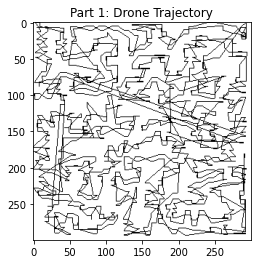

'\n#try different values of side length\nfor i in range(3,15):\n    #Part 1: Visualize the drone trajectory\n    edge_collection = edges_path(i, grid, sensors)\n    edge_min_set_cov = min_set_cover(edge_collection,sensors)\n    edge_grid = np.ones((300, 300))\n    for edge in edge_min_set_cov.keys():\n        if edge[0][0] == edge[1][0]:\n            edge_grid[edge[0][0],edge[0][1]:edge[1][1]] = 0\n        elif edge[0][1] == edge[1][1]:\n            edge_grid[edge[0][0]:edge[1][0],edge[0][1]] = 0\n    h,y = edge_connecting_algorithm((150,150),edge_min_set_cov)\n    print(path_length_calculation(y,edge_grid,i))\n    plt.imshow(edge_grid, cmap=plt.cm.gray)\n    plt.title("Part 1: Drone Trajectory: Length " + str(i))\n    plt.show()\n'

In [ ]:
# %% Main Loop

#Part 1: Visualize the drone trajectory
#obtain the edges and min set covers of the sensors
edge_collection = edges_path(6, grid, sensors)
edge_min_set_cov = min_set_cover(edge_collection,sensors)
edge_grid = np.ones((300, 300))
#color the edges and the path connecting edge to edge
for edge in edge_min_set_cov.keys():
    if edge[0][0] == edge[1][0]:
        edge_grid[edge[0][0],edge[0][1]:edge[1][1]] = 0
    elif edge[0][1] == edge[1][1]:
        edge_grid[edge[0][0]:edge[1][0],edge[0][1]] = 0
h,y = edge_connecting_algorithm((150,150),edge_min_set_cov)
#calculate the path length
print(path_length_calculation(y,edge_grid,6,sensors))
plt.imshow(edge_grid, cmap=plt.cm.gray)
plt.title("Part 1: Drone Trajectory")
plt.show()

#The following code was used for optimizing the side length of the arbitrary "semi-squares"
'''
#try different values of side length
for i in range(3,15):
    #Part 1: Visualize the drone trajectory
    edge_collection = edges_path(i, grid, sensors)
    edge_min_set_cov = min_set_cover(edge_collection,sensors)
    edge_grid = np.ones((300, 300))
    for edge in edge_min_set_cov.keys():
        if edge[0][0] == edge[1][0]:
            edge_grid[edge[0][0],edge[0][1]:edge[1][1]] = 0
        elif edge[0][1] == edge[1][1]:
            edge_grid[edge[0][0]:edge[1][0],edge[0][1]] = 0
    h,y = edge_connecting_algorithm((150,150),edge_min_set_cov)
    print(path_length_calculation(y,edge_grid,i))
    plt.imshow(edge_grid, cmap=plt.cm.gray)
    plt.title("Part 1: Drone Trajectory: Length " + str(i))
    plt.show()
'''

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


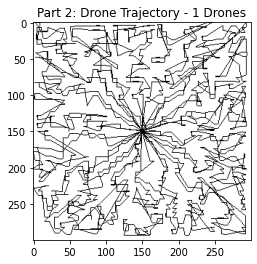

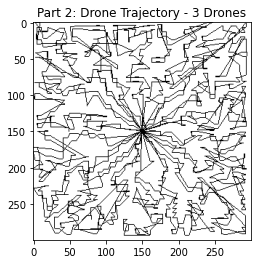

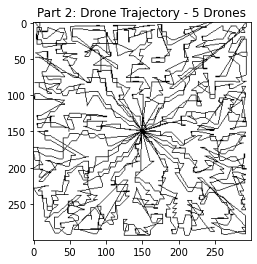

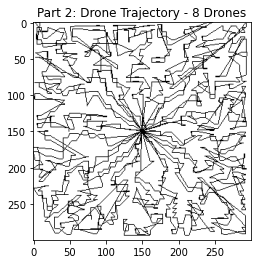

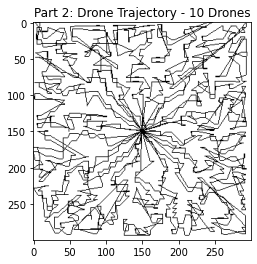

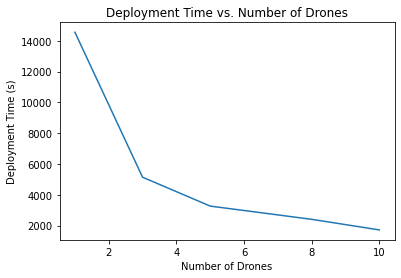

The optimal deployment ratio is: 172.3517072533582


In [ ]:
# %% Main Loop (Section 2)

#Part 2:
#using {1, 3, 5, 8, 10} drones, plot the resulting days
drone_num = [1, 3, 5, 8, 10]
edge_collection = edges_path(6, grid, sensors)
edge_min_set_cov = min_set_cover(edge_collection,sensors)
edge_grid = np.ones((300, 300))
h,y = edge_connecting_algorithm((150,150),edge_min_set_cov)
#the length for only one drone
seconds = []
#calculate the length for 1, 3, 5, 8, and 10 drones
for num in drone_num:
    #instantiate a new grid plot for every drone number
    edge_grid = np.ones((300, 300))
    for edge in edge_min_set_cov.keys():
        if edge[0][0] == edge[1][0]:
            edge_grid[edge[0][0],edge[0][1]:edge[1][1]] = 0
        elif edge[0][1] == edge[1][1]:
            edge_grid[edge[0][0]:edge[1][0],edge[0][1]] = 0
    ap = partition_algorithm((150,150), sensors, edge_min_set_cov, 6, 300, 1100,num)
    all_length_partitioned_path = []
    for Ap in ap:
        h, y = edge_connecting_algorithm((150,150),Ap)
        all_length_partitioned_path.append(path_length_calculation(y,edge_grid,6,sensors))
    seconds_collection = lists_of_similar_weight(all_length_partitioned_path, num)
    sum_seconds = []
    for s in seconds_collection:
        sum_seconds.append(sum(s))
    seconds.append(max(sum_seconds))
    plt.imshow(edge_grid, cmap=plt.cm.gray)
    plt.title("Part 2: Drone Trajectory - " + str(num)+ " Drones")
    plt.show()

plt.plot([1, 3, 5, 8, 10], seconds)
plt.xlabel("Number of Drones")
plt.ylabel("Deployment Time (s)")
plt.title("Deployment Time vs. Number of Drones")
plt.show()

deployment_ratio = []
num_drones = [1, 3, 5, 8, 10]
for i in range(5):
    deployment_ratio.append(seconds[i]/num_drones[i])
print("The optimal deployment ratio is: " + str(min(deployment_ratio)))